# Model Monitoring KPI Example
This notebook demonstrates how to use the `model_monitoring` module to define and analyze Key Performance Indicators (KPIs) across different data segments.

In [36]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

from model_monitoring import (
    InsuranceModelAnalysis,
    SegmentCategorical,
    SegmentCustom,
)
from model_monitoring.plotting import set_plot_theme

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Generate Synthetic Data

First, we'll create a synthetic dataset. This dataset mimics a typical insurance scenario with multiple coverages, predictions (risk premiums), and observed outcomes (targets/claims). The data is saved to a parquet file.

In [37]:
# --- Create a Synthetic Dataset ---
np.random.seed(42)
n_samples = 10000

# Create some numerical features
features = pd.DataFrame(
    {
        "age": np.random.randint(18, 70, n_samples),
        "income": np.random.gamma(2, 40000, n_samples),
        "credit_score": np.random.randint(300, 850, n_samples),
        "market_premium": np.random.uniform(0.1, 0.5, n_samples),
    }
)

# Create a categorical feature
features["region"] = np.random.choice(
    ["North", "South", "East", "West"], n_samples, p=[0.3, 0.2, 0.25, 0.25]
)

# --- Generate data for N=3 coverages in a wide format ---
N_coverages = 3
df = features.copy()

for i in range(N_coverages):
    cov_suffix = f"_{chr(65 + i)}"  # e.g., _A, _B, _C

    # --- Generate True Risk (rate for Poisson) ---
    true_risk_formula = (
        -4.0
        + (i * 0.1)
        + df["age"] / (20 + i * 2)
        - df["credit_score"] / (500 + i * 20)
        + df["income"] / 100000
    )
    true_risk_index = np.exp(true_risk_formula)

    # --- Generate a Slightly Incorrect Prediction ---
    prediction_formula = (
        -3.9
        + (i * 0.1)
        + df["age"] / (22 + i * 2)
        - df["credit_score"] / (550 + i * 20)
        + df["income"] / 110000
    )
    df[f"prediction{cov_suffix}"] = np.exp(prediction_formula)

    # --- Generate Target (claims) from the true risk ---
    df[f"target{cov_suffix}"] = np.random.poisson(true_risk_index)

# Add a single weight column
df["weight"] = 1.0

# Save to parquet
output_path = "../../data/segmentation_data.parquet"
df.to_parquet(output_path)

print(f"Synthetic data generated and saved to {output_path}")
df.head()

Synthetic data generated and saved to ../../data/segmentation_data.parquet


,age,income,credit_score,market_premium,region,prediction_A,target_A,prediction_B,target_B,prediction_C,target_C,weight
0,56,31626.419807,693,0.295256,West,0.097585,0,0.091178,0,0.087754,0,1.0
1,69,94350.676790,565,0.230289,East,0.393303,0,0.346978,1,0.317891,0,1.0
2,46,34226.773664,803,0.112133,South,0.051926,0,0.050744,0,0.050761,0,1.0
3,32,189107.488476,433,0.410269,North,0.220123,0,0.221539,0,0.226736,1,1.0
4,60,32588.089714,325,0.305161,South,0.230528,0,0.207231,0,0.192646,0,1.0


# Using Pre-configured Insurance Analysis Class

Now let's demonstrate how to use the new `InsuranceModelAnalysis` class that wraps all the analysis functionality in a reusable, standardized format. This class provides predictable outputs that can be easily integrated into larger reporting systems.

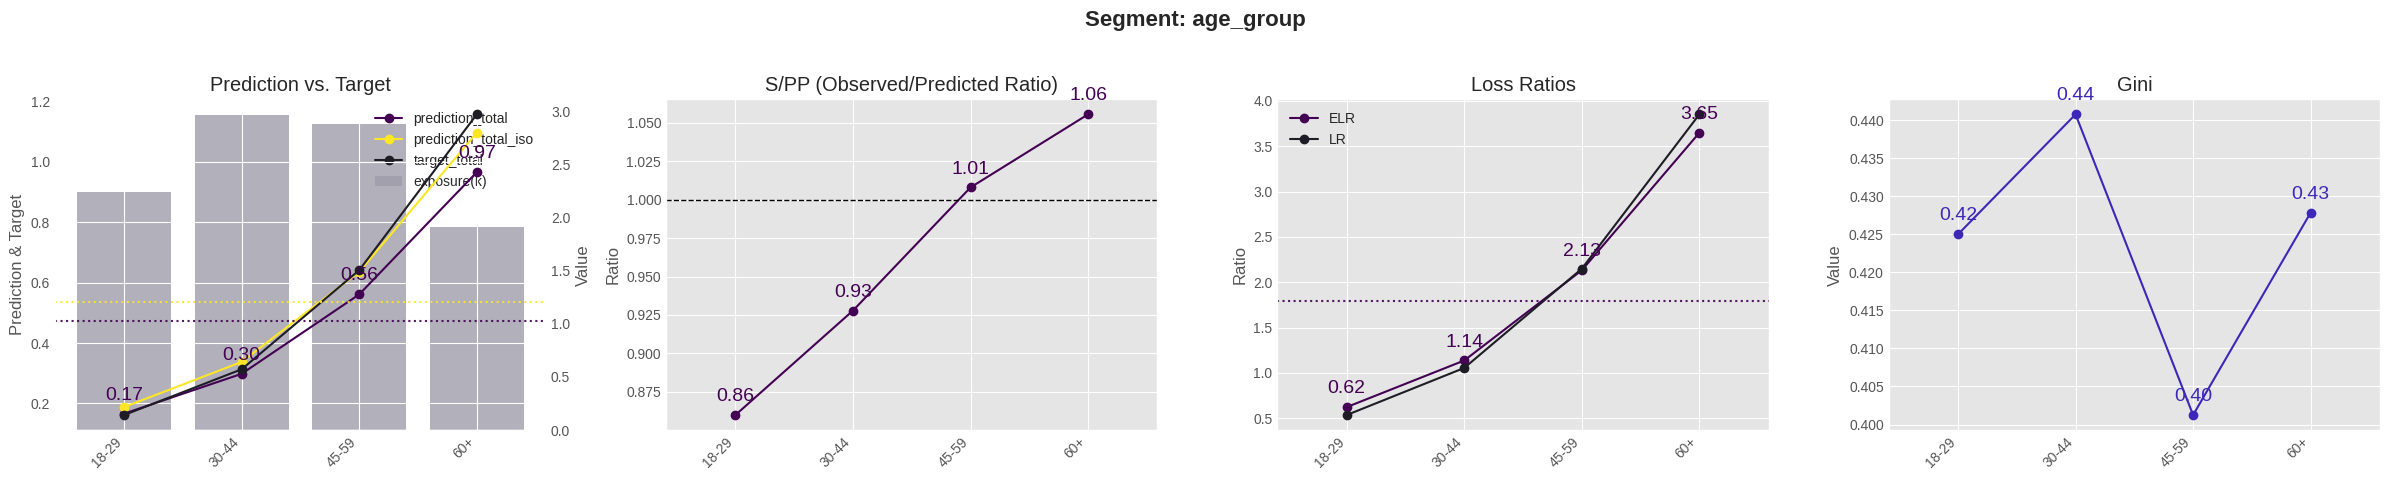

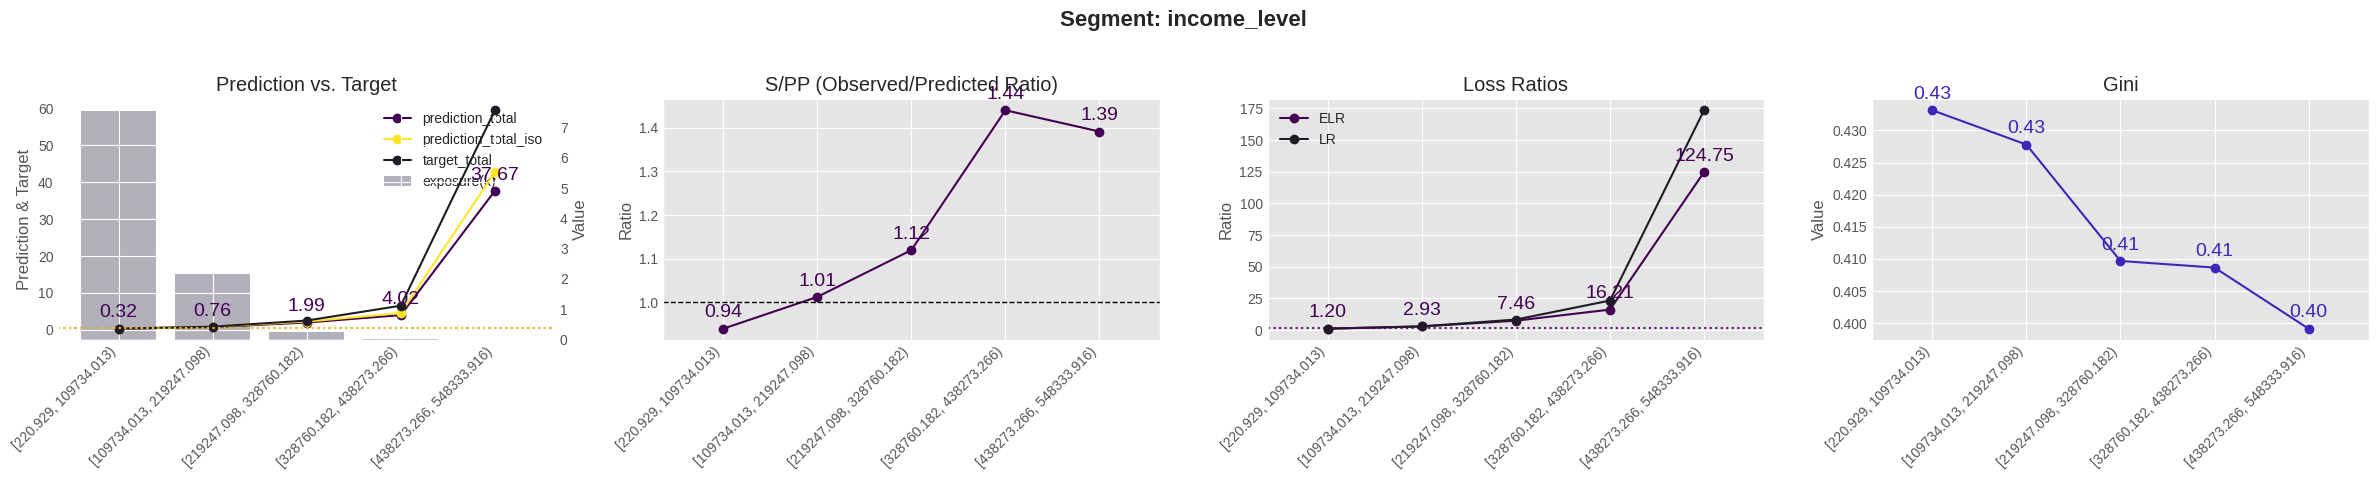

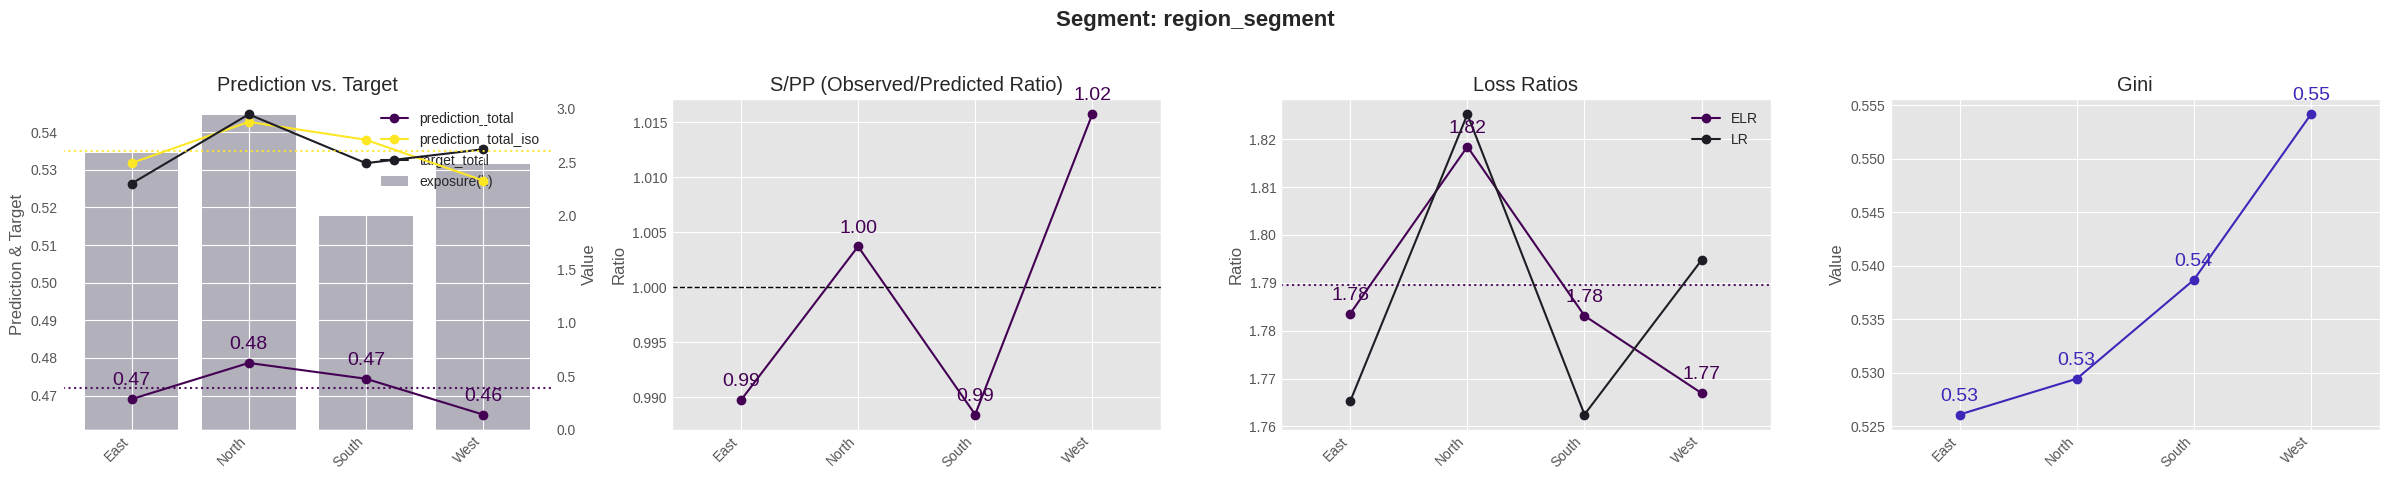

Analysis completed!
Available segments: ['age_group', 'income_level', 'region_segment']
Available coverages: ['A', 'B', 'C']

--- Aggregate Statistics ---


prediction_total         0.471967
prediction_total_iso     0.535100
target_total             0.535100
ELR                      1.789599
LR                       1.789599
gini                     0.536704
exposure(k)             10.000000
S/PP                     1.000000
diffLR-ELR               0.000000
dtype: float64

In [38]:
# --- Quick Analysis using Pre-configured Class ---
# Initialize the pre-configured insurance analysis
insurance_analysis = InsuranceModelAnalysis(
    data=output_path,
    bootstrap=False,  # Set to True for confidence intervals
)

# Run the complete analysis pipeline
analysis_results = insurance_analysis.run_analysis()

print("Analysis completed!")
print(f"Available segments: {insurance_analysis.get_segment_names()}")
print(f"Available coverages: {insurance_analysis.get_coverage_names()}")

print("\n--- Aggregate Statistics ---")
analysis_results["aggregate_statistics"]

In [39]:
# Access statistics for a specific segment
print("--- Age Group Segment Statistics ---")
analysis_results["segment_statistics"]["age_group"]

--- Age Group Segment Statistics ---


,prediction_total,prediction_total_iso,target_total,ELR,LR,gini,exposure(k),S/PP,diffLR-ELR,segment
age_group,,,,,,,,,,
18-29,0.166148,0.187868,0.161535,0.623343,0.535972,0.424993,2.241,0.859834,-0.087372,age_group
30-44,0.298072,0.337468,0.313111,1.137197,1.055118,0.440756,2.967,0.927823,-0.082079,age_group
45-59,0.561142,0.636211,0.641319,2.131861,2.148978,0.401249,2.880,1.008029,0.017117,age_group
60+,0.965933,1.096460,1.157427,3.647879,3.850711,0.427845,1.912,1.055603,0.202833,age_group


In [40]:
# The plots are already generated and available in the results
print("Available plots:", list(analysis_results["plots"].keys()))

# You can also save the analysis data for later use
insurance_analysis.save_data("../../data/insurance_analysis_results.json")

# Show metadata about the analysis
print("\n--- Analysis Metadata ---")
for key, value in analysis_results["metadata"].items():
    print(f"{key}: {value}")

Available plots: ['age_group', 'income_level', 'region_segment']
Analysis data saved to ../../data/insurance_analysis_results.json

--- Analysis Metadata ---
analysis_type: InsuranceModelAnalysis
bootstrap_enabled: False
n_resamples: None
ci_level: None
segments: ['age_group', 'income_level', 'region_segment']
coverages: ['A', 'B', 'C']


## Customizing the Pre-configured Analysis

The pre-configured class is still fully customizable. You can override any of the default configurations:

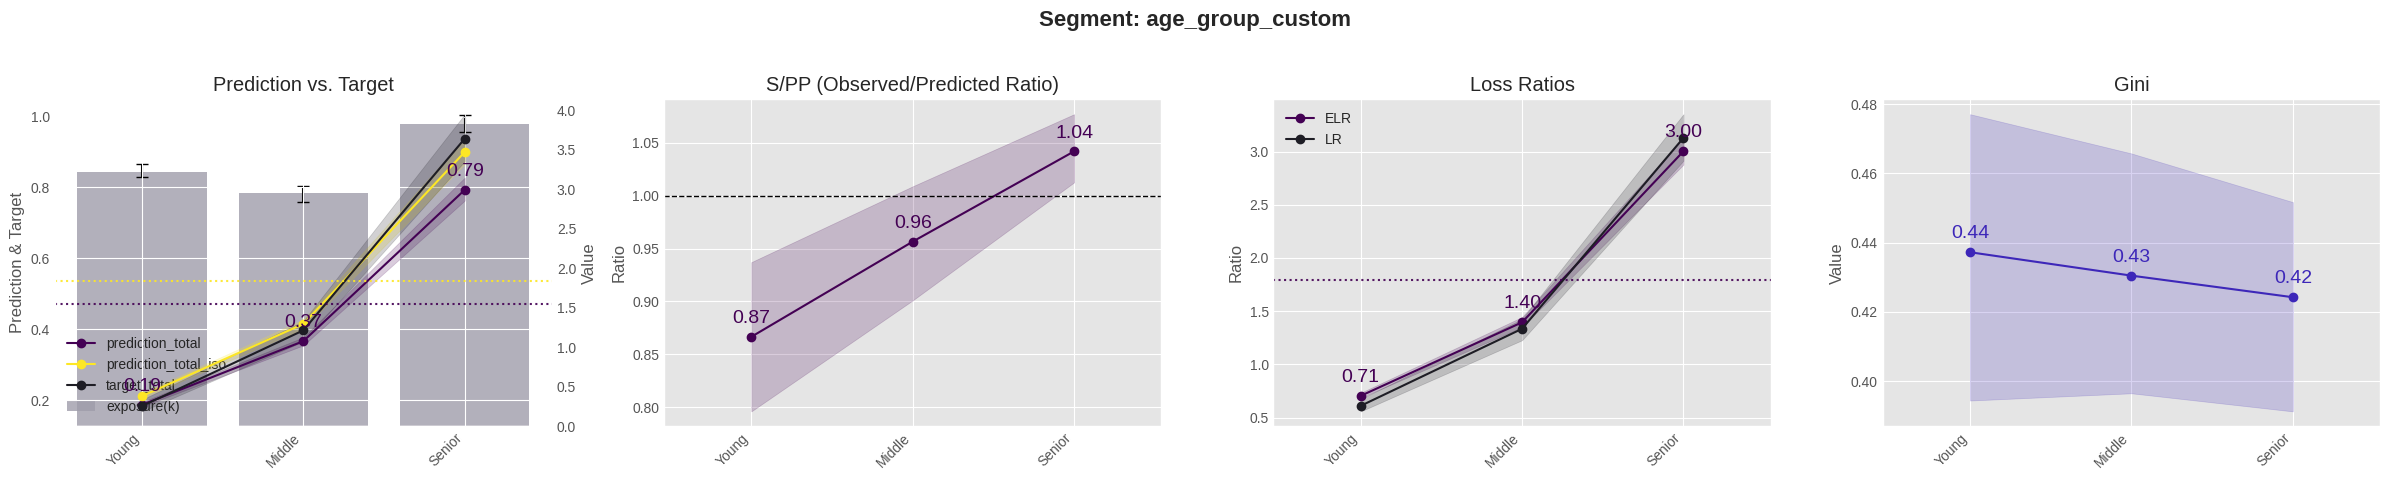

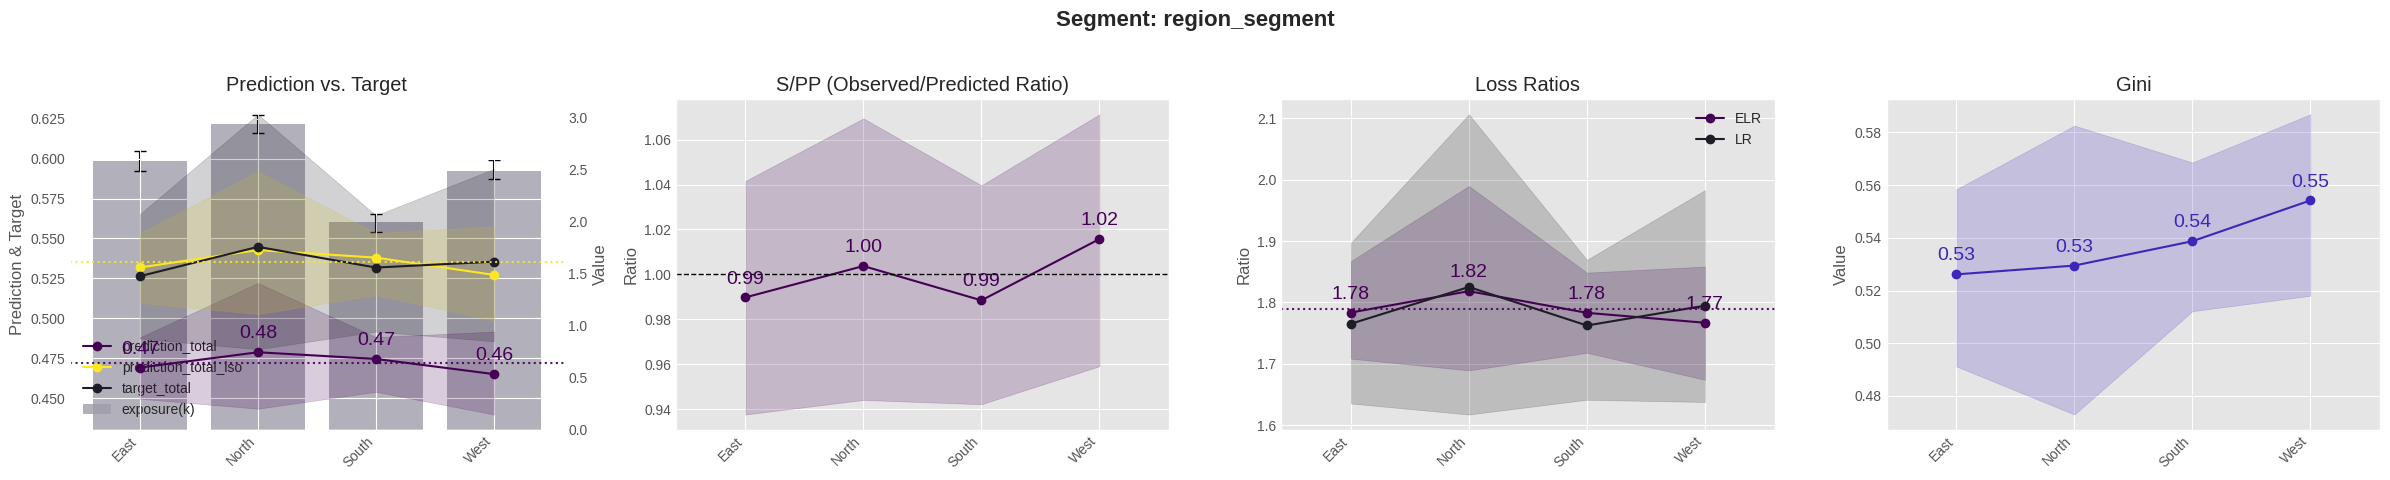

Customized Analysis completed!
Available segments: ['age_group_custom', 'region_segment']

--- Aggregate Statistics with CI ---


prediction_total_low         0.459506
prediction_total             0.471967
prediction_total_up          0.486859
prediction_total_iso_low     0.520955
prediction_total_iso         0.535100
prediction_total_iso_up      0.552016
target_total_low             0.510065
target_total                 0.535100
target_total_up              0.564335
ELR_low                      1.745219
ELR                          1.789599
ELR_up                       1.847177
LR_low                       1.708596
LR                           1.789599
LR_up                        1.885875
gini_low                     0.511896
gini                         0.536704
gini_up                      0.556483
exposure(k)_low             10.000000
exposure(k)                 10.000000
exposure(k)_up              10.000000
S/PP_low                     0.976170
S/PP                         1.000000
S/PP_up                      1.030348
diffLR-ELR_low              -0.041820
diffLR-ELR                   0.000000
diffLR-ELR_u

In [41]:
# --- Customize the Analysis ---
# Define custom segments (only age and region this time)
custom_segments = [
    SegmentCustom(
        seg_col="age",
        seg_name="age_group_custom",
        bins=[18, 35, 50, 75],
        bin_labels=["Young", "Middle", "Senior"],
    ),
    SegmentCategorical(seg_col="region", seg_name="region_segment"),
]

# Create customized analysis with bootstrap
custom_analysis = InsuranceModelAnalysis(
    data=output_path,
    segments=custom_segments,
    bootstrap=True,
    n_resamples=100,  # Reduced for speed
    ci_level=0.95,
)

# Run the customized analysis
custom_results = custom_analysis.run_analysis()

print("Customized Analysis completed!")
print(f"Available segments: {custom_analysis.get_segment_names()}")

print("\n--- Aggregate Statistics with CI ---")
custom_results["aggregate_statistics"]

## Integration with Larger Reporting Systems

The standardized output makes it easy to combine multiple analyses:

In [42]:
# Create a comprehensive report combining all analyses
import json
from datetime import datetime


def convert_keys_to_str(d):
    """Convert all keys in a nested dictionary to strings, including Interval keys"""
    if isinstance(d, dict):
        return {str(k): convert_keys_to_str(v) for k, v in d.items()}
    elif isinstance(d, list):
        return [convert_keys_to_str(item) for item in d]
    else:
        return d


# Get the analysis results using get_output method
default_results = insurance_analysis.get_output()
custom_results = custom_analysis.get_output()

# Combine all analyses into a single report
comprehensive_report = {
    "default_analysis": default_results,
    "custom_analysis": custom_results,
    "report_metadata": {
        "generated_at": datetime.now().isoformat(),
        "data_source": "../../data/segmentation_data.parquet",
        "analyses_performed": ["default_insurance", "custom_bootstrap_insurance"],
    },
}

print("Comprehensive report structure:")
for key, value in comprehensive_report.items():
    if key == "report_metadata":
        print(f"- {key}: {value}")
    else:
        print(f"- {key}: {type(value)}")
        if isinstance(value, dict) and "plots" in value:
            print(f"  - Plots: {len(value['plots'])} segments")
        if isinstance(value, dict) and "metadata" in value:
            print(f"  - Analysis type: {value['metadata']['analysis_type']}")
            print(f"  - Bootstrap: {value['metadata']['bootstrap_enabled']}")

# Convert to JSON-serializable format
report_copy = convert_keys_to_str(comprehensive_report)

# Save the comprehensive report
with open("../../data/comprehensive_analysis_report.json", "w") as f:
    json.dump(report_copy, f, indent=2, default=str)

print("\nComprehensive report saved to ../../data/comprehensive_analysis_report.json")

Comprehensive report structure:
- default_analysis: <class 'dict'>
  - Plots: 3 segments
  - Analysis type: InsuranceModelAnalysis
  - Bootstrap: False
- custom_analysis: <class 'dict'>
  - Plots: 2 segments
  - Analysis type: InsuranceModelAnalysis
  - Bootstrap: True
- report_metadata: {'generated_at': '2025-07-26T13:49:03.605270', 'data_source': '../../data/segmentation_data.parquet', 'analyses_performed': ['default_insurance', 'custom_bootstrap_insurance']}

Comprehensive report saved to ../../data/comprehensive_analysis_report.json


## Accessing Generated Plots

The plots are automatically generated and available in the results dictionary:

In [43]:
# Set the plotting theme for consistency
set_plot_theme(
    annotation_fontsize=14, style="ggplot", target_color="#1E1D25", h_line_style=":"
)

# Display a plot from the bootstrap analysis (with confidence intervals)
print("Example: Age Group Analysis with Confidence Intervals")
print("Available segments:", list(custom_results["plots"].keys()))

# The plots are displayed automatically when the analysis runs
# They are also stored for programmatic access
# Note: In a real reporting system, you would extract and save these plots

Example: Age Group Analysis with Confidence Intervals
Available segments: ['age_group_custom', 'region_segment']


## Different Analysis Types

The framework supports different types of pre-configured analyses. Here's an example using a simpler `BasicModelAnalysis`:

In [44]:
# Example 3: BasicModelAnalysis requires different data structure
# For this example, we'll skip the full execution and just show the concept

print("BasicModelAnalysis Example:")
print(
    "- Designed for simpler datasets with 'target_total' and 'prediction_total' columns"
)
print("- Provides essential KPIs with minimal configuration")
print("- Best suited for single-output models")
print()
print("Current synthetic data columns:", df.columns.tolist())
print("BasicModelAnalysis expects: ['target_total', 'prediction_total', 'weight', ...]")
print()
print("To use BasicModelAnalysis:")
print("1. Ensure your data has the expected column names")
print("2. Or customize the pred_dict in the constructor")
print("3. The class will automatically apply basic segmentation and statistics")

# Show what the analysis would produce
print("\nBasicModelAnalysis would provide:")
print("- Age group segmentation")
print("- Essential ratios (ELR, LR, Gini)")
print("- Bootstrap confidence intervals (if enabled)")
print("- Simplified visualizations")

BasicModelAnalysis Example:
- Designed for simpler datasets with 'target_total' and 'prediction_total' columns
- Provides essential KPIs with minimal configuration
- Best suited for single-output models

Current synthetic data columns: ['age', 'income', 'credit_score', 'market_premium', 'region', 'prediction_A', 'target_A', 'prediction_B', 'target_B', 'prediction_C', 'target_C', 'weight']
BasicModelAnalysis expects: ['target_total', 'prediction_total', 'weight', ...]

To use BasicModelAnalysis:
1. Ensure your data has the expected column names
2. Or customize the pred_dict in the constructor
3. The class will automatically apply basic segmentation and statistics

BasicModelAnalysis would provide:
- Age group segmentation
- Essential ratios (ELR, LR, Gini)
- Bootstrap confidence intervals (if enabled)
- Simplified visualizations
